In [1]:
%run -t numeric_mapping.py
data.head()

Hello World
Index(['Age', 'Race', 'Marital Status', 'T Stage', 'N Stage', '6th Stage',
       'differentiate', 'Grade', 'A Stage', 'Tumor Size', 'Estrogen Status',
       'Progesterone Status', 'Regional Node Examined',
       'Reginol Node Positive', 'Survival Months', 'Status'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   Age                     4024 non-null   int64
 1   T Stage                 4024 non-null   int64
 2   N Stage                 4024 non-null   int64
 3   6th Stage               4024 non-null   int64
 4   differentiate           4024 non-null   int64
 5   Grade                   4024 non-null   int64
 6   A Stage                 4024 non-null   int64
 7   Tumor Size              4024 non-null   int64
 8   Estrogen Status         4024 non-null   int64
 9   Progesterone Status    

C:\Users\jeanl\College\Blocks\Block 3\Epic\Block3Epic\random_forest\numeric_mapping.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,Age,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,1,1,4,1,3,0,4,1,1,24,1,60,1
1,50,2,2,7,2,2,0,35,1,1,14,5,62,1
2,58,3,3,9,2,2,0,63,1,1,14,7,75,1
3,58,1,1,4,1,3,0,18,1,1,2,1,84,1
4,47,2,1,5,1,3,0,41,1,1,3,1,50,1


In [58]:
#2 - Random Forest but regressive model. This might be better as we will be given an average umber rather than an estimated range.
#I would expect this to be less accurate as in right less often, but the mean squared error should be smaller.

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
np.random.seed(42)

#Input parameters = everything except survival months and status


x = data.drop(["Survival Months", "Status" ], axis=1)
y = data["Survival Months"]

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5)
# Use RandomForestRegressor for regression tasks

rf = RandomForestRegressor(random_state=42, n_estimators=1000, max_depth=5).fit(x_train, y_train)

# Making predictions based on the model
y_pred = rf.predict(x_test)
y_val_pred = rf.predict(x_val)


#Checking accuracy on validation set
mse_validation = mean_squared_error(y_val, y_val_pred)
print("Mean Squared Error on Validation Set:", mse_validation,"(((", str(mse_validation**0.5) + "))")

y_test_pred = rf.predict(x_test)
#Checking accuracy on test set
mse_test = mean_squared_error(y_test, y_test_pred)
print("Mean Squared Error on Test Set:", str(mse_test) + " ((" + str(mse_test**0.5) + "))")

# Getting feature importances
feature_importances = pd.DataFrame({'Feature': x.columns, 'Importance': rf.feature_importances_})

# Sorting features by importance in descending order
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Print or display the feature importances
print("Feature Importances:")
print(feature_importances)

#Before removing race and marital status: 413.27
#After removing race and marital status: 413.27
#After removing status: 548.0517. Worse, but in our case all future participants are alive, so this is not a good metric to use.
#After including validation set: 531.53
#removed regional nodes positive: V:541.67, T: 557.12
#After removing all features with importance less than 0.05: V: 607.887, T: 593.28. 
#Changing number of regressors from 100 to 1000: V: 589.54, T: 598.35
#Max tree depth of 2: V: 509.7, T: 529.26
#Max tree depth of 5: V: 503.4, T: 532.89
#Added all features except status and survival months: V: 481.84, T: 516.78




Mean Squared Error on Validation Set: 481.83933032442263 ((( 21.950838943521557))
Mean Squared Error on Test Set: 516.7823099685875 ((22.732846499472686))
Feature Importances:
                   Feature  Importance
7               Tumor Size    0.204337
11   Reginol Node Positive    0.188048
0                      Age    0.165207
10  Regional Node Examined    0.157315
8          Estrogen Status    0.103370
9      Progesterone Status    0.037171
3                6th Stage    0.032738
4            differentiate    0.028965
5                    Grade    0.027723
6                  A Stage    0.021520
2                  N Stage    0.019998
1                  T Stage    0.013608


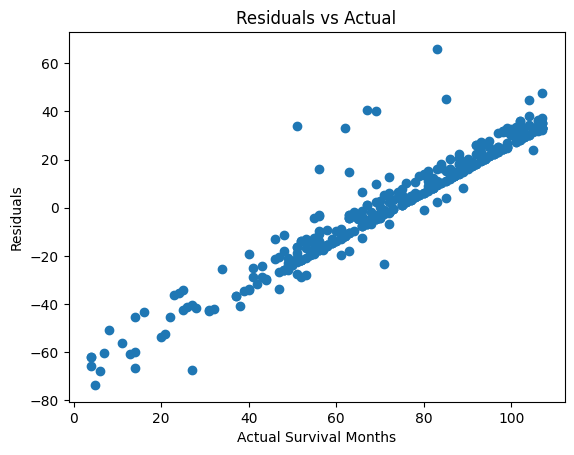

In [51]:
import matplotlib.pyplot as plt
residuals = y_test - y_test_pred
plt.scatter(y_test, residuals)
plt.xlabel('Actual Survival Months')
plt.ylabel('Residuals')
plt.title('Residuals vs Actual')
plt.show()

In [19]:
from sklearn.calibration import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
np.random.seed(42)



data_grouped = data.copy()
data_grouped['Survival Months Group'] = pd.cut(data_grouped['Survival Months'], bins=[0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, np.inf])

label_encoder = LabelEncoder()
data_grouped['Survival Months Group'] = label_encoder.fit_transform(data_grouped['Survival Months Group'])

x = data_grouped.drop(["Survival Months", "Status", "Reginol Node Positive"], axis=1)
y = data_grouped["Survival Months Group"]
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)


rf = RandomForestClassifier(random_state=0).fit(x_train, y_train)

y_pred = rf.predict(x_test)
y_val_pred = rf.predict(x_val)


# Checking the accuracy of the model
accuracy_test = accuracy_score(y_test, y_pred)
print("Accuracy on test only:", accuracy_test)

accuracy_validation = accuracy_score(y_val, y_val_pred)
print("Accuracy on validation only:", accuracy_validation)
#Before removing race and maritial status: 0.0211
#After removing race and marital status: 0.0224
#After removing status: 0.01129. Worse, but in our case all future participants are alive, so this is not a good metric to use.
#After including validation set: V: .893, T: .91066
#removed regional nodes positive: V: .9154, T: .9057


Accuracy on test only: 0.9379652605459057
Accuracy on validation only: 0.9427860696517413
